# Heart Disease Prediction

In [111]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (roc_auc_score, roc_curve,
                            confusion_matrix, classification_report,
                            ConfusionMatrixDisplay, PrecisionRecallDisplay)
from sklearn.inspection import permutation_importance
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [112]:
# path
my_path = '/content/drive/MyDrive/Projeto_01_ML/cleaned_merged_heart_dataset.csv'
my_path

'/content/drive/MyDrive/Projeto_01_ML/cleaned_merged_heart_dataset.csv'

In [113]:
# Carregar os dados
data = pd.read_csv(my_path)

In [123]:
class Architecture(object):
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class

        # We start by storing the arguments as attributes
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)

        # These attributes are defined here, but since they are
        # not informed at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None

        # These attributes are going to be computed internally
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

        # Creates the train_step function for our model,
        # loss function and optimizer
        # Note: there are NO ARGS there! It makes use of the class
        # attributes directly
        self.train_step_fn = self._make_train_step_fn()
        # Creates the val_step function for our model and loss
        self.val_step_fn = self._make_val_step_fn()

    def to(self, device):
        # This method allows the user to specify a different device
        # It sets the corresponding attribute (to be used later in
        # the mini-batches) and sends the model to the device
        try:
            self.device = device
            self.model.to(self.device)
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            print(f"Couldn't send it to {device}, sending it to {self.device} instead.")
            self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):
        # This method allows the user to define which train_loader (and val_loader, optionally) to use
        # Both loaders are then assigned to attributes of the class
        # So they can be referred to later
        self.train_loader = train_loader
        self.val_loader = val_loader

    def _make_train_step_fn(self):
        # This method does not need ARGS... it can refer to
        # the attributes: self.model, self.loss_fn and self.optimizer

        # Builds function that performs a step in the train loop
        def perform_train_step_fn(x, y):
            # Sets model to TRAIN mode
            self.model.train()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # Step 3 - Computes gradients for both "a" and "b" parameters
            loss.backward()
            # Step 4 - Updates parameters using gradients and the learning rate
            self.optimizer.step()
            self.optimizer.zero_grad()

            # Returns the loss
            return loss.item()

        # Returns the function that will be called inside the train loop
        return perform_train_step_fn

    def _make_val_step_fn(self):
        # Builds function that performs a step in the validation loop
        def perform_val_step_fn(x, y):
            # Sets model to EVAL mode
            self.model.eval()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # There is no need to compute Steps 3 and 4, since we don't update parameters during evaluation
            return loss.item()

        return perform_val_step_fn

    def _mini_batch(self, validation=False):
        # The mini-batch can be used with both loaders
        # The argument `validation`defines which loader and
        # corresponding step function is going to be used
        if validation:
            data_loader = self.val_loader
            step_fn = self.val_step_fn
        else:
            data_loader = self.train_loader
            step_fn = self.train_step_fn

        if data_loader is None:
            return None

        # Once the data loader and step function, this is the same
        # mini-batch loop we had before
        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            mini_batch_loss = step_fn(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

        loss = np.mean(mini_batch_losses)
        return loss

    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)

    def train(self, n_epochs, seed=42):
        # To ensure reproducibility of the training process
        self.set_seed(seed)

        for epoch in range(n_epochs):
            # Keeps track of the numbers of epochs
            # by updating the corresponding attribute
            self.total_epochs += 1

            # inner loop
            # Performs training using mini-batches
            loss = self._mini_batch(validation=False)
            self.losses.append(loss)

            # VALIDATION
            # no gradients in validation!
            with torch.no_grad():
                # Performs evaluation using mini-batches
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)

    def save_checkpoint(self, filename):
        # Builds dictionary with all elements for resuming training
        checkpoint = {'epoch': self.total_epochs,
                      'model_state_dict': self.model.state_dict(),
                      'optimizer_state_dict': self.optimizer.state_dict(),
                      'loss': self.losses,
                      'val_loss': self.val_losses}

        torch.save(checkpoint, filename)

    def load_checkpoint(self, filename):
        # Loads dictionary
        checkpoint = torch.load(filename,weights_only=False)

        # Restore state for model and optimizer
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']

        self.model.train() # always use TRAIN for resuming training

    def predict(self, x):
        # Set is to evaluation mode for predictions
        self.model.eval()
        # Takes aNumpy input and make it a float tensor
        x_tensor = torch.as_tensor(x).float()
        # Send input to device and uses model for prediction
        y_hat_tensor = self.model(x_tensor.to(self.device))
        # Set it back to train mode
        self.model.train()
        # Detaches it, brings it to CPU and back to Numpy
        return y_hat_tensor.detach().cpu().numpy()

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig

In [124]:
# Define a wrapper class for the PyTorch model
class TorchEstimatorWrapper:
    def __init__(self, model):
        self.model = model
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model.to(self.device)

    # Dummy fit method to satisfy scikit-learn interface
    def fit(self, X, y):
        # The model is assumed to be already trained
        return self

    # Method to predict probabilities
    def predict_proba(self, X):
        self.model.eval() # Set model to evaluation mode
        with torch.no_grad(): # No gradients needed for prediction
            # Convert numpy array to torch tensor and move to device
            x_tensor = torch.as_tensor(X).float().to(self.device)
            # Get raw logits
            logits = self.model(x_tensor)
            # Apply sigmoid to get probabilities for the positive class (class 1)
            probabilities = torch.sigmoid(logits)
        self.model.train() # Set model back to training mode
        # Return probabilities as a numpy array, ensuring correct shape (n_samples, 2)
        # For binary classification, predict_proba typically returns probabilities for both classes.
        # We can return (1 - prob_class_1, prob_class_1)
        prob_class_1 = probabilities.detach().cpu().numpy()
        prob_class_0 = 1 - prob_class_1
        return np.hstack((prob_class_0, prob_class_1))

    # Optional: Method to predict class labels (if needed for other metrics)
    def predict(self, X):
        probs = self.predict_proba(X)[:, 1] # Get probability of class 1
        return (probs > 0.5).astype(int) # Apply threshold

In [125]:
# Separar features e target
X = data.drop('target', axis=1).values
y = data['target'].values

In [126]:
# Dividir e padronizar
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)


In [127]:
# Converter para tensores
train_dataset = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).float().unsqueeze(1))
val_dataset = TensorDataset(torch.tensor(X_val).float(), torch.tensor(y_val).float().unsqueeze(1))


In [128]:
# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

In [129]:
# Modelo (redefined to ensure it's the one being used)
#model = nn.Sequential(nn.Linear(13, 1))
#optimizer = optim.Adam(model.parameters(), lr=0.001)
#loss_fn = nn.BCEWithLogitsLoss()

In [130]:
lr = 0.001

torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(13, 1))

# Defines a SGD optimizer to update the parameters
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a BCE loss function
loss_fn = nn.BCEWithLogitsLoss()

In [131]:
# Treinar (re-instantiate and train)
arch = Architecture(model, loss_fn, optimizer)
arch.set_loaders(train_loader, val_loader)
arch.train(n_epochs=500) # Reduced epochs for quicker execution if needed

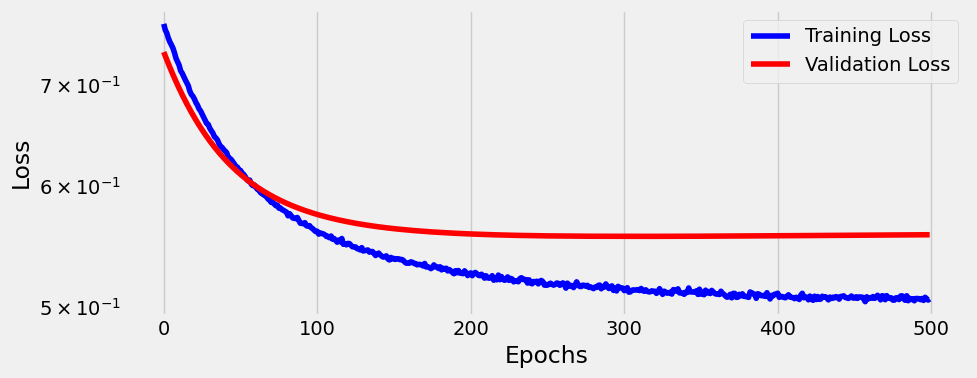

In [132]:
# Plotar perdas
arch.plot_losses()
plt.show()


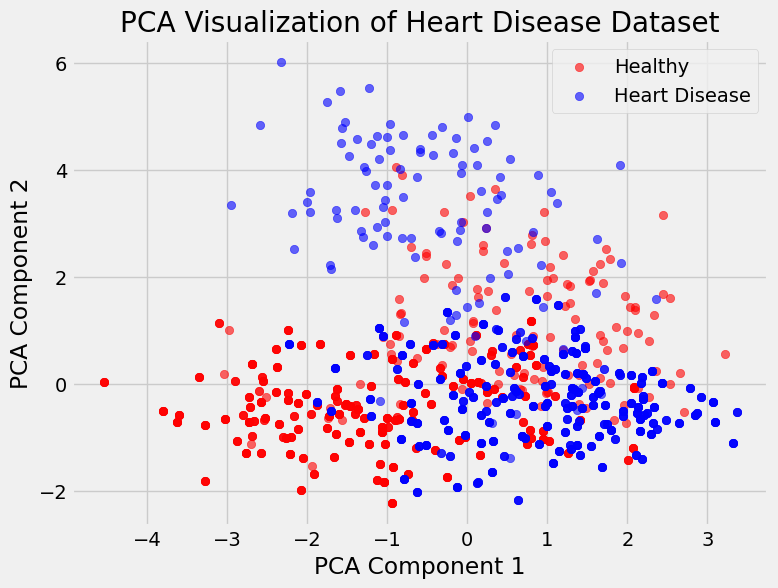

In [133]:
# 1. Visualização com PCA (Redução para 2D) - Ensure this part uses the scaled data
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
plt.figure(figsize=(8,6))
plt.scatter(X_train_pca[y_train==0, 0], X_train_pca[y_train==0, 1], c='red', label='Healthy', alpha=0.6)
plt.scatter(X_train_pca[y_train==1, 0], X_train_pca[y_train==1, 1], c='blue', label='Heart Disease', alpha=0.6)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Visualization of Heart Disease Dataset')
plt.legend()
plt.show()


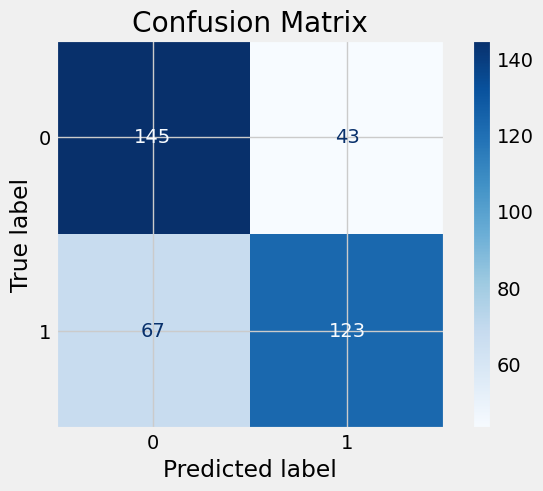

In [134]:
# 2. Matriz de Confusão
y_probs = arch.predict(X_val) # Use the predict method from Architecture for consistency
y_pred = (y_probs > 0.5).astype(int)

cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

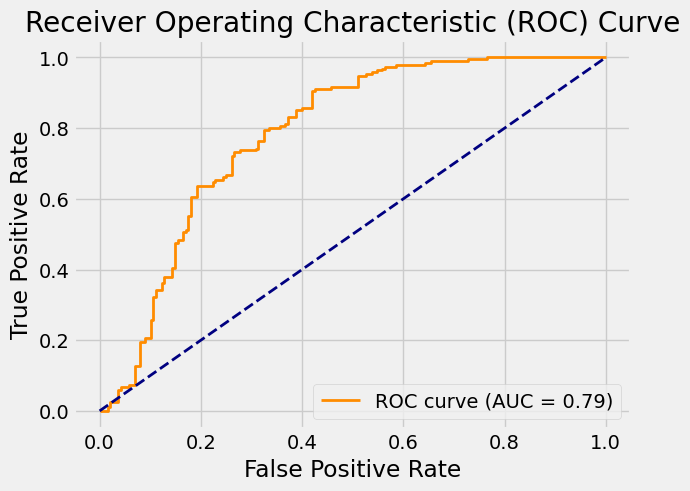

In [135]:
# 3. Curva ROC e AUC
# Use the predict method from Architecture and apply sigmoid to get probabilities for ROC AUC
y_probs_for_auc = torch.sigmoid(torch.as_tensor(arch.predict(X_val)).float()).detach().cpu().numpy().squeeze()

fpr, tpr, _ = roc_curve(y_val, y_probs_for_auc)
roc_auc = roc_auc_score(y_val, y_probs_for_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [136]:
# 4. Relatório de Classificação
print("\nClassification Report:")
# Use the predicted classes (y_pred) for the classification report
print(classification_report(y_val, y_pred, target_names=['No Heart Disease', 'Heart Disease']))


Classification Report:
                  precision    recall  f1-score   support

No Heart Disease       0.68      0.77      0.72       188
   Heart Disease       0.74      0.65      0.69       190

        accuracy                           0.71       378
       macro avg       0.71      0.71      0.71       378
    weighted avg       0.71      0.71      0.71       378

